In [41]:
%load_ext autoreload
%autoreload 2
 
import sys
sys.path.append('../src')
import xgboost as xgb
import pandas as pd
import numpy as np
from features.UserJoin import UserJoin
from features.UserJoin import submit, diff, plt_month, plt_day, load_ids, info, infot
import config as C
import matplotlib.pyplot as plt

from xgb_search import exp
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns
from xgboost import plot_tree
import random
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import itertools
sns.set_style("ticks",{'axes.grid' : True})

pd.options.display.max_columns = 500
plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ds = UserJoin()

In [6]:
ds.day.columns

Index(['rq', 'kwh', 'kwh_rap', 'kwh_pap_r1', 'kwh_pap_r2', 'kwh_pap_r3',
       'kwh_pap_r4', 'kwh_cal', 'pr2', 'pr3', 'pr4', '   ', 'ELEC_TYPE_NAME',
       'VOLT_NAME', 'PRC_NAME', 'CONTRACT_CAP', 'RUN_CAP', 'SHIFT_NO',
       'BUILD_DATE', 'CANCEL_DATE', 'CHK_CYCLE', 'LAST_CHK_DATE', 'TMP_NAME',
       'TMP_DATE', 'IS_FLAG', 'label', '2_3', '2_4', '3_4', 'daycv', 'type'],
      dtype='object')

In [8]:
daydf = ds.day.drop(columns=['kwh',
                             'kwh_rap',
                             '   ',
                             'PRC_NAME',
                             'CONTRACT_CAP',
                             'RUN_CAP',
                             'SHIFT_NO',
                             'BUILD_DATE',
                             'CANCEL_DATE',
                             'CHK_CYCLE',
                             'LAST_CHK_DATE',
                             'TMP_NAME',
                             'TMP_DATE'])

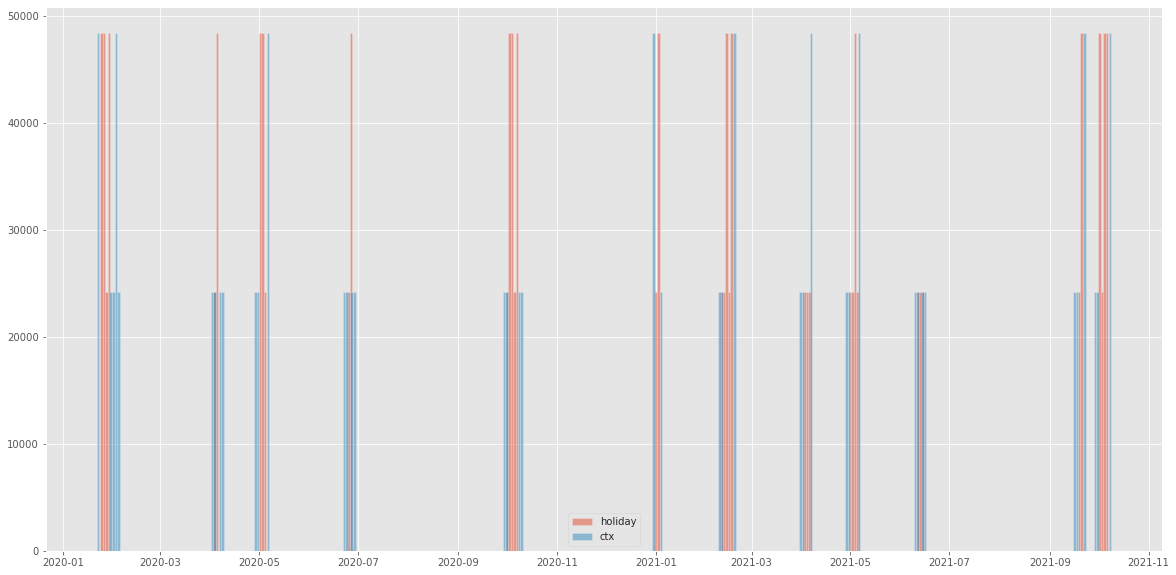

In [47]:
daydf.query('type == 0').rq.hist(bins=400, figsize=(20, 10), alpha=.5, label='holiday')
daydf.query('type != 0').rq.hist(bins=400, figsize=(20, 10), alpha=.5, label='ctx')
plt.legend()
plt.show()

In [62]:
rq_lst = daydf.rq.sort_values().unique()
dct = {}
count = 0
dct[rq_lst[0]] = count

for i in range(1, len(rq_lst)):
    if (rq_lst[i] - rq_lst[i-1]) != np.timedelta64(1, 'D'):
        count += 1
    dct[rq_lst[i]] = count

In [76]:
daydf['hol_n'] = daydf.rq.map(dct)

In [85]:
daydf

,rq,kwh_pap_r1,kwh_pap_r2,kwh_pap_r3,kwh_pap_r4,kwh_cal,pr2,pr3,pr4,ELEC_TYPE_NAME,VOLT_NAME,IS_FLAG,label,2_3,2_4,3_4,daycv,type,hol_n
id,,,,,,,,,,,,,,,,,,,
179404030,2020-01-22,0.0,33.47,0.0,18.31,51.78,0.646389,0.0,0.353611,城镇居民生活用电,交流380V,NaN,test,0.646389,0.292777,0.353611,0.971013,-1,0
179404030,2020-01-23,0.0,51.83,0.0,21.44,73.27,0.707384,0.0,0.292616,城镇居民生活用电,交流380V,NaN,test,0.707384,0.414767,0.292616,1.066335,-1,0
179404030,2020-01-24,0.0,52.20,0.0,22.70,74.90,0.696929,0.0,0.303071,城镇居民生活用电,交流380V,NaN,test,0.696929,0.393858,0.303071,1.048346,0,0
179404030,2020-01-25,0.0,37.27,0.0,25.45,62.72,0.594228,0.0,0.405772,城镇居民生活用电,交流380V,NaN,test,0.594228,0.188457,0.405772,0.910994,0,0
179404030,2020-01-26,0.0,41.72,0.0,22.56,64.28,0.649035,0.0,0.350965,城镇居民生活用电,交流380V,NaN,test,0.649035,0.298071,0.350965,0.974630,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880712108,2021-10-05,0.0,22.14,0.0,22.71,44.85,0.493645,0.0,0.506355,乡村居民生活用电,交流220V,NaN,test,0.493645,0.012709,0.506355,0.866235,0,11
2880712108,2021-10-06,0.0,14.94,0.0,13.95,28.89,0.517134,0.0,0.482866,乡村居民生活用电,交流220V,NaN,test,0.517134,0.034268,0.482866,0.867549,0,11
2880712108,2021-10-07,0.0,27.27,0.0,23.84,51.11,0.533555,0.0,0.466445,乡村居民生活用电,交流220V,NaN,test,0.533555,0.067110,0.466445,0.871856,0,11


In [86]:
daydf.columns

Index(['rq', 'kwh_pap_r1', 'kwh_pap_r2', 'kwh_pap_r3', 'kwh_pap_r4', 'kwh_cal',
       'pr2', 'pr3', 'pr4', 'ELEC_TYPE_NAME', 'VOLT_NAME', 'IS_FLAG', 'label',
       '2_3', '2_4', '3_4', 'daycv', 'type', 'hol_n'],
      dtype='object')

In [117]:
cols = ['kwh_pap_r1', 'kwh_pap_r2', 'kwh_pap_r3', 'kwh_pap_r4', 'kwh_cal']
holcv = daydf.groupby(['id', 'hol_n'])[cols].std() / (daydf.groupby(['id', 'hol_n'])[cols].mean() + 1e-5)
holcv = holcv.reset_index()

In [171]:
holcv.loc[holcv.id.isin(C.true_ids), 'isminer'] = 1
holcv.loc[holcv.id.isin(C.false_ids), 'isminer'] = 0
holcv.loc[holcv.id.isin(C.minerids), 'isminer'] = 2
holcv_mean = holcv[holcv.id.isin(C.true_ids | C.false_ids | set(C.minerids))].groupby(['isminer', 'id', 'isminer2']).mean()
holcv_mean[set(cols) - {'kwh_pap_r1'}].T.style.background_gradient()

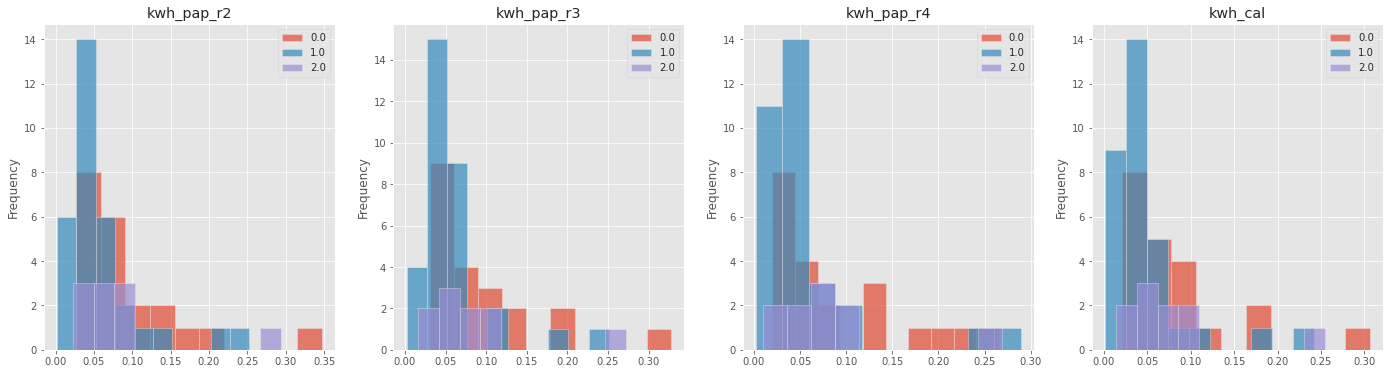

In [192]:
fig, axs = plt.subplots(1, 4, figsize=(24,6))
for i, c in enumerate(['kwh_pap_r2', 'kwh_pap_r3', 'kwh_pap_r4', 'kwh_cal']):
    holcv_mean.groupby('isminer')[c].plot(title=c, kind='hist',alpha=.7, legend=True, ax=axs[i])
plt.legend()
plt.show()

In [195]:
ds.train

,ELEC_TYPE_NAME,VOLT_NAME,RUN_CAP,label,kwh,kwh_cal,kwh_pap_r2,kwh_pap_r3,kwh_pap_r4,pr2,pr3,pr4,2_3,2_4,3_4,daycv,kwh_holiday_1,kwh_cal_holiday_1,kwh_pap_r2_holiday_1,kwh_pap_r3_holiday_1,kwh_pap_r4_holiday_1,pr2_holiday_1,pr3_holiday_1,pr4_holiday_1,2_3_holiday_1,2_4_holiday_1,3_4_holiday_1,daycv_holiday_1,kwh_holiday_0,kwh_cal_holiday_0,kwh_pap_r2_holiday_0,kwh_pap_r3_holiday_0,kwh_pap_r4_holiday_0,pr2_holiday_0,pr3_holiday_0,pr4_holiday_0,2_3_holiday_0,2_4_holiday_0,3_4_holiday_0,daycv_holiday_0,kwh_holiday_diff,kwh_cal_holiday_diff,kwh_pap_r2_holiday_diff,kwh_pap_r3_holiday_diff,kwh_pap_r4_holiday_diff,pr2_holiday_diff,pr3_holiday_diff,pr4_holiday_diff,2_3_holiday_diff,2_4_holiday_diff,3_4_holiday_diff,daycv_holiday_diff,pq_f,pq_g,pq_p,pq_z,pp,pf,pg,p_f,p_g,f_g,monthcv,ELEC_TYPE_NAME_CODE,VOLT_NAME_CODE
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
329465205,乡村居民生活用电,交流220V,4.0,0,17.723178,17.722804,11.790935,0.000000,5.931869,0.657183,0.000000,0.342817,0.657183,0.340257,0.342817,1.040713,15.854737,15.854386,11.176140,0.00000,4.678246,0.679416,0.000000,0.320584,0.679416,0.388637,0.320584,1.081183,19.8532,19.8528,12.4918,0.00,7.3610,0.631839,0.00000,0.368161,0.631839,0.285103,0.368161,0.994577,-3.998463,-3.998414,-1.315660,0.00000,-2.682754,0.047577,0.000000,-0.047577,0.047577,0.103534,-0.047577,0.086607,444.809524,250.238095,0.095238,695.142857,0.000260,0.648618,0.351122,0.648359,0.350862,0.297497,0.983860,0,1
329465245,乡村居民生活用电,交流220V,4.0,0,34.517944,34.518131,23.671495,0.000000,10.846636,0.681968,0.000000,0.308686,0.681968,0.373281,0.308686,1.035656,35.038070,35.038772,24.029474,0.00000,11.009298,0.687786,0.000000,0.312214,0.687786,0.375572,0.312214,1.044507,33.9250,33.9246,23.2634,0.00,10.6612,0.675335,0.00000,0.304665,0.675335,0.370670,0.304665,1.025566,1.113070,1.114172,0.766074,0.00000,0.348098,0.012451,0.000000,0.007549,0.012451,0.004902,0.007549,0.018941,670.333333,310.714286,0.000000,981.047619,0.000025,0.687396,0.312579,0.687372,0.312554,0.374817,1.036359,0,1
329465357,乡村居民生活用电,交流220V,8.0,0,54.653271,54.653271,43.415701,0.000000,11.237570,0.785142,0.000000,0.205512,0.785142,0.579631,0.205512,1.226316,57.480877,57.480877,46.041754,0.00000,11.439123,0.799047,0.000000,0.200953,0.799047,0.598094,0.200953,1.251220,51.4298,51.4298,40.4220,0.00,11.0078,0.769291,0.00000,0.210709,0.769291,0.558583,0.210709,1.197925,6.051077,6.051077,5.619754,0.00000,0.431323,0.029755,0.000000,-0.009755,0.029755,0.039511,-0.009755,0.053295,95.952381,31.000000,1505.523810,1632.476190,0.928215,0.054251,0.017534,0.945596,0.934286,0.036717,1.649252,0,1
329465360,乡村居民生活用电,交流220V,2.0,0,34.197757,34.198037,24.496355,0.000000,9.701682,0.717844,0.000000,0.272810,0.717844,0.445033,0.272810,1.096507,35.740526,35.740877,25.694386,0.00000,10.046491,0.726426,0.000000,0.273574,0.726426,0.452852,0.273574,1.110203,32.4390,32.4392,23.1306,0.00,9.3086,0.708060,0.00000,0.271940,0.708060,0.436120,0.271940,1.080894,3.301526,3.301677,2.563786,0.00000,0.737891,0.018366,0.000000,0.001634,0.018366,0.016732,0.001634,0.029309,723.095238,302.238095,0.095238,1025.428571,0.000075,0.711996,0.287929,0.711921,0.287854,0.424066,1.078630,0,1
329465439,乡村居民生活用电,交流220V,8.0,0,33.965234,33.965234,24.343832,0.000000,9.621402,0.711382,0.000000,0.279272,0.711382,0.432110,0.279272,1.085375,33.729649,33.729649,24.630877,0.00000,9.098772,0.731669,0.000000,0.268331,0.731669,0.463338,0.268331,1.117743,34.2338,34.2338,24.0166,0.00,10.2172,0.688256,0.00000,0.291744,0.688256,0.396511,0.291744,1.048475,-0.504151,-0.504151,0.614277,0.00000,-1.118428,0.043413,0.000000,-0.023413,0.043413,0.066827,-0.023413,0.069268,0.000000,0.000000,1130.952381,1130.952381,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.732051,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.